## Importing Libraries

In [ ]:
import pubchempy as pcp
import pandas as pd
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn import tree
import graphviz
from sklearn.model_selection import GridSearchCV
from imblearn.metrics import geometric_mean_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from rdkit import Chem
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import copy
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras

# Apply the default theme
sns.set_theme()

warnings.filterwarnings("ignore")

## Getting Data Using APIs

In [ ]:
df = pd.read_csv('/content/Assay List CCTE_Padilla_ZF_144hpf_TERATOSCORE_up-2022-11-07 (2).csv')

# df = pd.read_csv('/content/mix test.csv')

In [ ]:
print("Number of inactive cases is: ", df.where(df["HIT CALL"] == "Inactive").count()[0])
print("Number of active cases is: ", df.where(df["HIT CALL"] == "Active").count()[0])

Number of inactive cases is:  223
Number of active cases is:  497


In [ ]:
df.isnull().any()

DTXSID               False
PREFERRED NAME       False
CASRN                False
MOLECULAR FORMULA     True
MONOISOTOPIC MASS    False
ToxCast Active       False
ToxCast Total        False
% ToxCast Active     False
HIT CALL             False
TOP                   True
SCALED TOP            True
AC50                  True
LOGAC50               True
dtype: bool

In [ ]:
df = df.drop(columns=["ToxCast Active", "ToxCast Total", "% ToxCast Active", "CASRN", "TOP", "SCALED TOP", "LOGAC50", "AC50", "DTXSID", 'MOLECULAR FORMULA', 'MONOISOTOPIC MASS'])

In [ ]:
df.dropna(inplace=True)
df.head(3)

,PREFERRED NAME,HIT CALL
0,Sodium L-ascorbate,Active
1,Chlorothalonil,Active
2,Acifluorfen,Inactive


In [ ]:
compounds = []
for i in df["PREFERRED NAME"]:
  try:
    compounds.append(pcp.get_compounds(i, 'name'))
    time.sleep(0.5)
  except TypeError or URLError:
    print(i)

In [ ]:
df['compounds'] = compounds
df.head(3)

In [ ]:
df = df.where(df["compounds"].str.len() == 1).dropna()

In [ ]:
for index, row in df.iterrows():
  c = row["compounds"][0]
  df.loc[index, 'Hydrogen_Bond_Donor_Count'] = c.h_bond_donor_count
  df.loc[index, 'Hydrogen_Bond_Acceptor_Count'] = c.h_bond_acceptor_count
  df.loc[index, 'Formal_Charge'] = c.charge
  df.loc[index, 'Mw'] = c.molecular_weight
  df.loc[index, 'canonical_smiles'] = c.canonical_smiles
  df.loc[index, 'xlogp'] = c.xlogp
  df.loc[index, 'exact_mass'] = c.exact_mass

In [ ]:
df["Formal_Charge"].plot()

In [ ]:
df = df.drop(columns=['Formal_Charge'])

In [ ]:
mols = []
df.dropna()
from rdkit.Chem import AllChem, MACCSkeys, Descriptors
for smiles in df["canonical_smiles"]:
  mol = Chem.MolFromSmiles(smiles)
  mols.append(mol)

df["mol"] = mols

for index, row in df.iterrows():
  mol = row["mol"]
  df.loc[index,'NumHeteroatoms'] = Descriptors.NumHeteroatoms(mol)
  df.loc[index,'NumRotatableBonds'] = Descriptors.NumRotatableBonds(mol)
  df.loc[index,'NumHeavyAtoms'] = Descriptors.HeavyAtomCount (mol)
  df.loc[index,'NumAliphaticCarbocycles'] = Descriptors.NumAliphaticCarbocycles(mol)
  df.loc[index,'NumAliphaticHeterocycles'] = Descriptors.NumAliphaticHeterocycles(mol)
  df.loc[index,'NumAliphaticRings'] = Descriptors.NumAliphaticRings(mol)
  df.loc[index,'NumAromaticCarbocycles'] = Descriptors.NumAromaticCarbocycles(mol)
  df.loc[index,'NumAromaticHeterocycles'] = Descriptors.NumAromaticHeterocycles(mol)
  df.loc[index,'NumAromaticRings'] = Descriptors.NumAromaticRings(mol)
  df.loc[index,'RingCount'] = Descriptors.RingCount(mol)
  df.loc[index,'FractionCSP3'] = Descriptors.FractionCSP3(mol)
  df.loc[index,'NHOHCount'] = Descriptors.NHOHCount(mol)
  df.loc[index,'NOCount'] = Descriptors.NOCount(mol)
  df.loc[index,'NumValenceElectrons'] = Descriptors.NumValenceElectrons(mol)
  df.loc[index,'TPSA'] = Descriptors.TPSA(mol)

In [ ]:
df.dropna(inplace=True)
df.head(3)

In [ ]:
print("Number of inactive cases is: \t", df.where(df["HIT CALL"] == "Inactive").dropna().count()[0])
print("Number of active cases is: \t", df.where(df["HIT CALL"] == "Active").dropna().count()[0])

## Cleaning Data and Data Visualization

In [ ]:
df['Mw'] = df['Mw'].map(lambda x: float(x))
df['exact_mass'] = df['exact_mass'].map(lambda x: float(x))

In [ ]:
features = ['Hydrogen_Bond_Donor_Count',
 'Hydrogen_Bond_Acceptor_Count',
 'Mw',
 'xlogp',
 'NumHeteroatoms',
 'NumRotatableBonds',
 'NumHeavyAtoms',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'RingCount',
 'FractionCSP3',
 'NHOHCount',
 'NOCount',
 'NumValenceElectrons',
 'TPSA']

In [ ]:
df.to_csv("final_output.csv")

In [ ]:
for f in features:
  print(f, " stdv: \t\t\t\t", df[f].std())

In [ ]:
df['Mw'].corr(df['exact_mass'])

In [ ]:
corr_matrix = df.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.color_palette("PiYG", as_cmap=True)
sns.heatmap(corr_matrix, cmap = "PiYG")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
df = df.drop(columns=['PREFERRED NAME', 'mol', 'canonical_smiles', 'compounds', 'exact_mass'])

In [ ]:
df.to_csv("final_output.csv")

In [ ]:
print(df.groupby("HIT CALL").mean())

In [ ]:
numerical_features = [
    'NumHeteroatoms', 'NumValenceElectrons', 'NOCount', 'Hydrogen_Bond_Acceptor_Count', 'NumAromaticRings', 'NHOHCount', 'RingCount', 'NumAliphaticRings', 
    'NumAromaticHeterocycles', 'NumAromaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticCarbocycles', 'NumHeavyAtoms', 'NumRotatableBonds'
]

In [ ]:
for f in numerical_features:
  sns.displot(data=df, x=f, col="HIT CALL", kde=True)

## Feature Engineering

In [ ]:
def has_feature(feature):
  if feature > 0:
    return 1
  else:
    return 0

In [ ]:
new_features = []
for f in numerical_features:
  new_name = "Has"
  if 'Count' in f:
    new_name = f.replace("Count", "")
  elif 'Num' in f:
    new_name = f.replace("Num", "")
  new_features.append(new_name)
  df[new_name] = df[f].apply(has_feature)

In [ ]:
total_features = new_features + features

In [ ]:
X = df[total_features]
y = df["HIT CALL"]

y = y.replace("Active", 1)
y = y.replace("Inactive", 0)

In [ ]:
scaler = StandardScaler()
stand_X = copy.deepcopy(X)
stand_X[features] = scaler.fit_transform(X[features])
stand_X = pd.DataFrame(stand_X, index=X.index, columns=X.columns)

In [ ]:
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(stand_X, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
df.to_csv('final_output.csv')

## Feature Selection

### ANOVA (Analysis of Variance)

In [ ]:
f_values, p_values = f_classif(X_train_stand, y_train_stand)

# Create a DataFrame with feature scores and p-values
scores_df = pd.DataFrame({'Feature': X_train_stand.columns, 'F-Score': f_values, 'p-value': p_values})

# Sort the features by F-Score in descending order
scores_df = scores_df.sort_values(by='F-Score', ascending=False)

# Print the sorted DataFrame
print(scores_df)

### Desicion Tree

In [ ]:
tree_clf = ExtraTreesClassifier()
tree_clf = tree_clf.fit(X_train, y_train)

In [ ]:
tree_feature_selection = pd.DataFrame({"features": X_train.columns.to_list(), "Importance": tree_clf.feature_importances_.tolist()}).sort_values(by="Importance", ascending=False)
print(tree_feature_selection)

In [ ]:
tree_features = tree_feature_selection.where(tree_feature_selection["Importance"] > 0.050).dropna()['features'].to_list()

### L2 Feature Selection

In [ ]:
lr = LinearSVC(C=1, penalty="l2").fit(X_train_stand, y_train_stand)
sel = SelectFromModel(lr, prefit=True)

In [ ]:
SVC_feature_selection = pd.DataFrame({"features": X_train.columns.to_list(), "Importance": sel.get_support().tolist()})
print(SVC_feature_selection.sort_values(by="Importance", ascending=False))

In [ ]:
L2_features = SVC_feature_selection.where(SVC_feature_selection["Importance"] == True).dropna()['features'].to_list()

## Building Models

### Using Class Weightening

In [ ]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)

gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train, y_train, sample_weight = list(map(lambda x: class_weights[1] if x == 1 else class_weights[0], y_train)))
y_pred = gb_classifier.predict(X_test)
mcc_score = matthews_corrcoef(y_test, y_pred)

print("MCC score on the test set: {:.2f}".format(mcc_score))

### Oversampling

In [ ]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

print(y_sm.value_counts())

In [ ]:
smote = SMOTE(sampling_strategy='minority')
stand_X_sm, stand_y_sm = smote.fit_resample(stand_X, y)

stand_y_sm.value_counts()

In [ ]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)
stand_X_train_sm, stand_X_test_sm, stand_y_train_sm, stand_y_test_sm = train_test_split(stand_X_sm, stand_y_sm, test_size=0.3, random_state=42)

### Adding Cross Validation

#### Functions

In [ ]:
def GradientBoostingClassifier_function(selected_features=total_features):
  # class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
  # print("class_weights: ", class_weights)

  model = GradientBoostingClassifier()

  param_grid = {
      'n_estimators': [50, 100, 200],
      'learning_rate': [0.1, 0.05, 0.01],
      'max_depth': [3, 4, 5]
  }

  # Perform grid search with cross-validation
  gb_classifier = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
  gb_classifier.fit(X_train_sm, y_train_sm)

  # Print the best hyperparameters and the corresponding accuracy score
  print('Best hyperparameters:', gb_classifier.best_params_)


  # gb_classifier = GradientBoostingClassifier()

  kf = KFold(n_splits=10, shuffle=True, random_state=42)
  scores = np.zeros(10)

  for i, (train_index, test_index) in enumerate(kf.split(X_train_sm[selected_features])):
      X_train_fk, X_test_fk = X_train_sm[selected_features].iloc[train_index], X_train_sm[selected_features].iloc[test_index]
      y_train_fk, y_test_fk = y_train_sm.iloc[train_index], y_train_sm.iloc[test_index]
      
      # Fit the model on the training data
      # gb_classifier.fit(X_train_fk, y_train_fk, sample_weight=list(map(lambda x: class_weights[1] if x == 1 else class_weights[0], y_train_fk)))
      gb_classifier.fit(X_train_fk, y_train_fk)
      
      # Calculate the score on the test data and store it
      score = gb_classifier.score(X_test_fk, y_test_fk)
      scores[i] = score
      
  # Print the cross-validation scores and the average score
  # print("Cross-validation scores:", scores)
  # print("Average score:", np.mean(scores))

  y_pred = gb_classifier.predict(X_test_sm[selected_features])
  mcc_score = matthews_corrcoef(y_test_sm, y_pred)

  print("MCC score on the test set for GradientBoostingClassifier is: {:.2f}".format(mcc_score))

In [ ]:
def KNN_function(selected_features=total_features):

  model = KNeighborsClassifier()

  param_grid = {'n_neighbors': [3, 5, 7, 9],
              'metrix': ['manhattan', 'euclidean', 'cosine', 'minkowski'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
              }

  # Perform grid search with cross-validation
  knn_classifier = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
  knn_classifier.fit(X_train_sm, y_train_sm)

  # Print the best hyperparameters and the corresponding accuracy score
  print('Best hyperparameters:', knn_classifier.best_params_)

  # knn_classifier = KNeighborsClassifier()

  kf = KFold(n_splits=10, shuffle=True, random_state=42)
  scores = np.zeros(10)

  for i, (train_index, test_index) in enumerate(kf.split(stand_X_train_sm[selected_features])):
      X_train_fk, X_test_fk = stand_X_train_sm[selected_features].iloc[train_index], stand_X_train_sm[selected_features].iloc[test_index]
      y_train_fk, y_test_fk = y_train_sm.iloc[train_index], y_train_sm.iloc[test_index]
      
      knn_classifier.fit(X_train_fk, y_train_fk)

      score = knn_classifier.score(X_test_fk, y_test_fk)
      scores[i] = score

  y_pred = knn_classifier.predict(stand_X_test_sm[selected_features])
  mcc_score = matthews_corrcoef(y_test_sm, y_pred)

  print("MCC score on the test set for KNNClassifier is: {:.2f}".format(mcc_score))

In [ ]:
def LogisticRegression_function(selected_features=total_features):

  model = LogisticRegression()

  # Define the parameter grid
  param_grid = {
      'penalty': ['l1', 'l2', 'elasticnet', 'none'],
      'C': [0.1, 1, 10],
      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
  }

  # Perform grid search with cross-validation
  lr_classifier = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
  lr_classifier.fit(X_train_sm, y_train_sm)

  # Print the best hyperparameters and the corresponding accuracy score
  print('Best hyperparameters:', lr_classifier.best_params_)


  # lr_classifier = LogisticRegression()

  kf = KFold(n_splits=10, shuffle=True, random_state=42)
  scores = np.zeros(10)

  for i, (train_index, test_index) in enumerate(kf.split(X_train_sm[selected_features])):
      X_train_fk, X_test_fk = X_train_sm[selected_features].iloc[train_index], X_train_sm[selected_features].iloc[test_index]
      y_train_fk, y_test_fk = y_train_sm.iloc[train_index], y_train_sm.iloc[test_index]
      
      lr_classifier.fit(X_train_fk, y_train_fk)

      score = lr_classifier.score(X_test_fk, y_test_fk)
      scores[i] = score

  y_pred = lr_classifier.predict(X_test_sm[selected_features])
  mcc_score = matthews_corrcoef(y_test_sm, y_pred)

  print("MCC score on the test set for LogisticRegression is: {:.2f}".format(mcc_score))

In [ ]:
from math import sqrt
def mcc(tp, fp, tn, fn):
    x = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return ((tp * tn) - (fp * fn)) / sqrt(x)

In [ ]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [ ]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

def NN_function(selected_features=total_features):
  # model = Sequential()
  # # model.add(Dense(16, activation='relu', kernel_initializer='he_normal', input_shape=(33,)))
  # # model.add(Dense(8, activation='relu'))
  # # model.add(Dense(4, activation='relu'))
  # # model.add(Dense(1, activation='sigmoid'))

  # model.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(33,), kernel_regularizer=regularizers.l2(0.01)))
  # model.add(Dropout(0.2))
  # model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  # model.add(Dropout(0.2))

  # model.add(Dense(1, activation='sigmoid'))

  model = Sequential([
      Dense(64, activation='relu', input_shape=(33,)),
      Dropout(0.2),
      Dense(64, activation='relu'),
      Dropout(0.2),
      Dense(1, activation='sigmoid')
  ])
  
  METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
  ]

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
  history = model.fit(stand_X_train_sm[selected_features], stand_y_train_sm, epochs=2000, batch_size=200, verbose=0)

  acc = model.evaluate(stand_X_test_sm[selected_features], stand_y_test_sm, verbose=0)

  print(acc)
  print("MCC score on the test set for NN is: {:.2f}".format(mcc(acc[1], acc[2], acc[3], acc[4])))

  plot_loss(history, "LOSS", 0)

#### Calling Functions

In [ ]:
GradientBoostingClassifier_function()

In [ ]:
KNN_function()

In [ ]:
LogisticRegression_function()

In [ ]:
NN_function()

##### Selecting Features by a Threshold

In [ ]:
def select_features(num, sorted_features, first_or_last='first'):
  if first_or_last == 'first':
    return sorted_features["features"][:num]
  elif first_or_last == 'last':
    return sorted_features["features"][-1*num:]

In [ ]:
selected_sorted_features = select_features(10, tree_feature_selection, 'first')
GradientBoostingClassifier_function(selected_sorted_features)
KNN_function(selected_sorted_features)
LogisticRegression_function(selected_sorted_features)
# NN_function(selected_sorted_features)

MCC score on the test set for GradientBoostingClassifier is: 0.58
MCC score on the test set for KNNClassifier is: 0.45
MCC score on the test set for LogisticRegression is: 0.38


In [ ]:
selected_sorted_features = select_features(10, tree_feature_selection, 'last')
GradientBoostingClassifier_function(selected_sorted_features)
KNN_function(selected_sorted_features)
LogisticRegression_function(selected_sorted_features)

MCC score on the test set for GradientBoostingClassifier is: 0.34
MCC score on the test set for KNNClassifier is: 0.05
MCC score on the test set for LogisticRegression is: 0.32


In [ ]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

def NN_function(selected_features=total_features):
  model = Sequential()
  model.add(Dense(25, activation='relu', kernel_initializer='he_normal', input_shape=(len(selected_features),), kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(0.1))
  model.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(0.05))

  model.add(Dense(1, activation='sigmoid'))
  
  METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
  ]

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
  history = model.fit(stand_X_train_sm[selected_features], stand_y_train_sm, epochs=2000, batch_size=200, verbose=0)

  acc = model.evaluate(stand_X_test_sm[selected_features], stand_y_test_sm, verbose=0)

  print(acc)
  print("MCC score on the test set for NN is: {:.2f}".format(mcc(acc[1], acc[2], acc[3], acc[4])))

  plot_loss(history, "LOSS", 0)

[0.6316667199134827, 103.0, 17.0, 107.0, 25.0, 0.8333333134651184, 0.8583333492279053, 0.8046875, 0.8676915764808655, 0.8495879173278809]
MCC score on the test set for NN is: 0.67


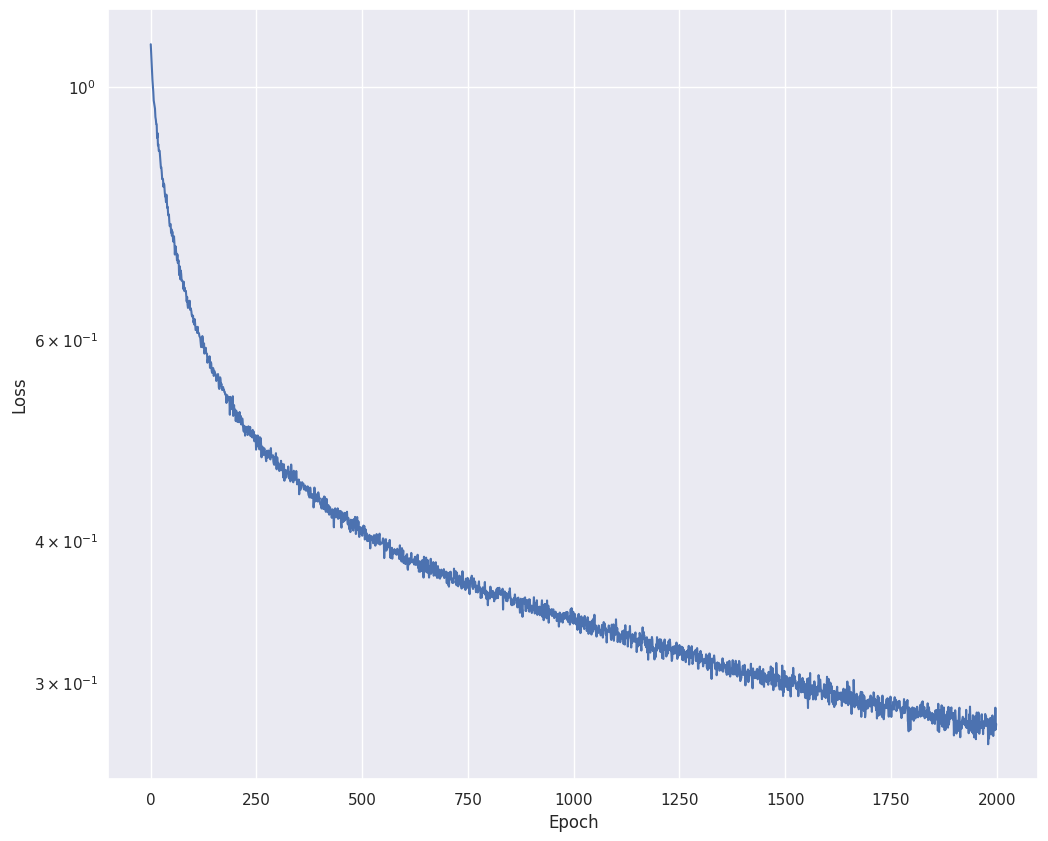

In [ ]:
# selected_sorted_features = select_features(10, tree_feature_selection, 'first')
NN_function_10()

In [ ]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

def NN_function_10(selected_features=total_features):
  model = Sequential()
  model.add(Dense(15, activation='relu', kernel_initializer='he_normal', input_shape=(len(selected_features),), kernel_regularizer=regularizers.l2(0.01)))
  # model.add(Dropout(0.1))
  # model.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(0.05))

  model.add(Dense(1, activation='sigmoid'))
  
  METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
  ]

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
  history = model.fit(stand_X_train_sm[selected_features], stand_y_train_sm, epochs=2000, batch_size=200, verbose=0)

  acc = model.evaluate(stand_X_test_sm[selected_features], stand_y_test_sm, verbose=0)

  print(acc)
  print("MCC score on the test set for NN is: {:.2f}".format(mcc(acc[1], acc[2], acc[3], acc[4])))

  plot_loss(history, "LOSS", 0)

[0.6675671935081482, 91.0, 67.0, 57.0, 37.0, 0.5873016119003296, 0.5759493708610535, 0.7109375, 0.6232988834381104, 0.6227648258209229]
MCC score on the test set for NN is: 0.18


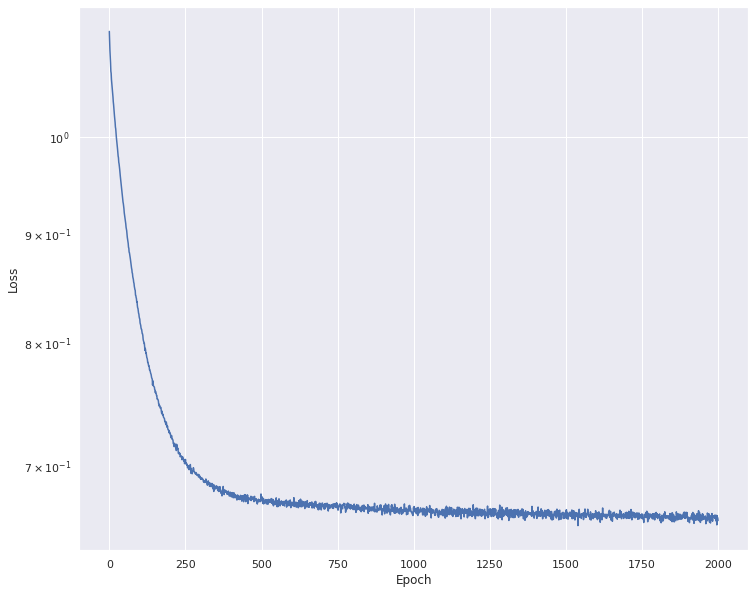

In [ ]:
selected_sorted_features = select_features(10, tree_feature_selection, 'last')
NN_function_10(selected_sorted_features)

[0.5334789752960205, 91.0, 28.0, 96.0, 37.0, 0.7420634627342224, 0.7647058963775635, 0.7109375, 0.8473411798477173, 0.8637109398841858]
MCC score on the test set for NN is: 0.49


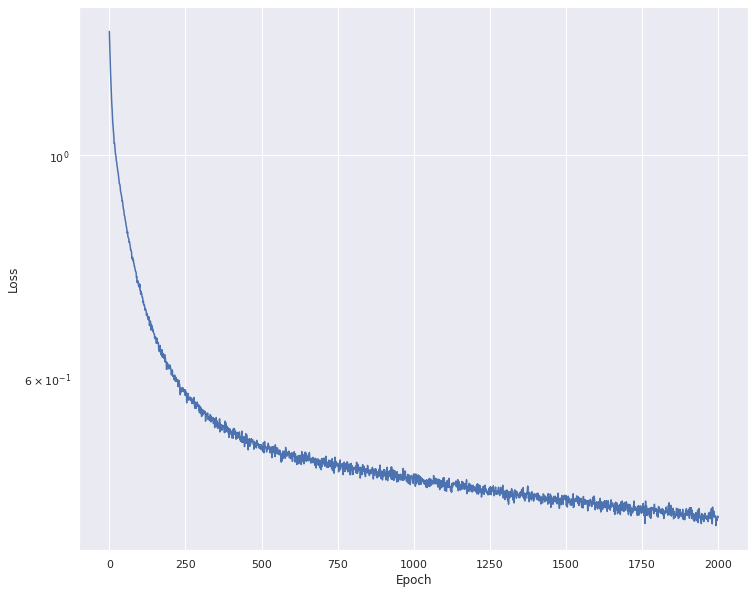

In [ ]:
selected_sorted_features = select_features(10, tree_feature_selection, 'first')
NN_function_10(selected_sorted_features)

In [ ]:
from scipy.stats import ttest_rel

mcc_before = 0.51
mcc_after = 0.44

t_statistic, p_value = ttest_rel([mcc_before], [mcc_after])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: nan
p-value: nan


In [ ]:
stand_X_train_sm.duplicated().sum()

3